In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"priyajitbera","key":"a6c124f225c125b08546fa77aebabd98"}'}

In [2]:
#placing the api file in right directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 777 ~/.kaggle/kaggle.json

**Downloading Emoji Image the Dataset from Kaggle**

In [3]:
!kaggle datasets download -d subinium/emojiimage-dataset

 86% 41.0M/47.6M [00:00<00:00, 50.0MB/s]
100% 47.6M/47.6M [00:00<00:00, 73.7MB/s]


**Extracting the Dataset**

In [4]:
#Extracting the images from Dataset
from zipfile import ZipFile
file_name = 'emojiimage-dataset.zip'

with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done')

Done


**Renaming the folders containing the images**

In [5]:
!mv ./image ./emoji_images

**Imports**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras.utils import load_img, img_to_array
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras import layers
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras import models
from tensorflow.keras.optimizers import Adam

**Loading the Face images of the Emojis**

In [22]:
#we will only train the model with the emojis which are face shaped
X_train = []

dataset_dir = '/content/emoji_images/Google'
img_names = os.listdir(dataset_dir)
# for img_name in img_names:
for i in range(1,120):
    img_path = os.path.join(dataset_dir,str(i)+'.png')
    img = cv2.imread(img_path)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    X_train.append(RGB_img)
X_train = np.array(X_train)

**We loaded 119 72x72 images**

In [23]:
X_train.shape

(119, 72, 72)

**Visualizing one sample**

(-0.5, 71.5, 71.5, -0.5)

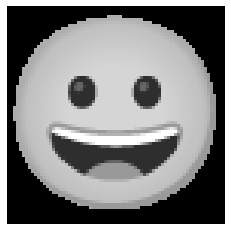

In [12]:
plt.imshow(X_train[0], cmap='gray')
plt.axis('off')

**Visualizing entire training batch**

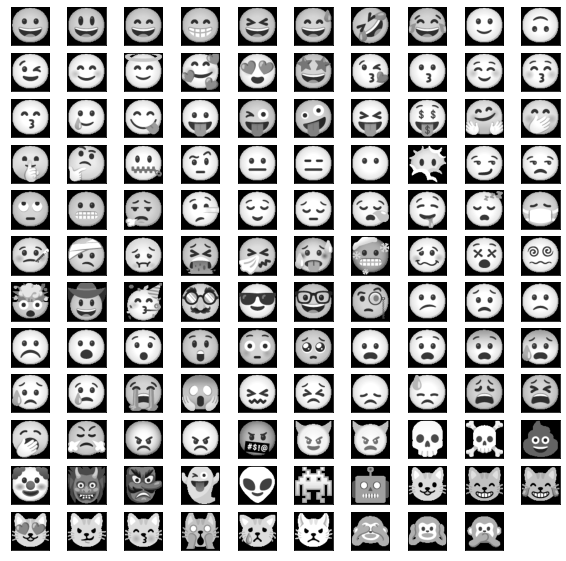

In [26]:
plt.figure(figsize =(10, 10))
for i in range(119):
    plt.subplot(12, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap = 'gray')
plt.show()

**Defining our image dimentions**

In [33]:
img_height = 72
img_width = 72
channels = 1
img_shape = (img_height, img_width, channels)
img_shape

(72, 72, 1)

**Defining the function to buil the Generator(G) model**

In [27]:
def build_generator():
    noise_shape = (100,)

    G = Sequential()

    G.add(Dense(256, input_shape=noise_shape))
    G.add(LeakyReLU(alpha=0.2))
    G.add(BatchNormalization(momentum=0.8))

    G.add(Dense(512))
    G.add(LeakyReLU(alpha=0.2))
    G.add(BatchNormalization(momentum=0.8))

    G.add(Dense(1024))
    G.add(LeakyReLU(alpha=0.2))
    G.add(BatchNormalization(momentum=0.8))
    
    G.add(Dense(2048))
    G.add(LeakyReLU(alpha=0.2))
    G.add(BatchNormalization(momentum=0.8))
    
    G.add(Dense(np.prod(img_shape), activation='tanh'))
    G.add(Reshape(img_shape))

    G.summary()

    noise = Input(shape=noise_shape)
    generated_img = G(noise)

    return Model(noise, generated_img)

**Defining the model to build the Discriminator(D) model**

In [28]:
def build_discriminator():

    D = Sequential()

    D.add(Flatten(input_shape=img_shape))
    D.add(Dense(512))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dense(256))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dense(128))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dense(1, activation='sigmoid'))
    D.summary()

    img = Input(shape=img_shape)
    validity = D(img)

    return Model(img, validity)

**Defining the function to train the Discriminator and Generator**

In [29]:
def train(epochs=500, batch_size=128, save_interval=50, X_train=[]):

    X_train = (X_train.astype(np.float32) -127.5) /127.5

    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for ep in range(1, epochs+1):
        #Traning Discriminator D
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0,1, (half_batch, 100))

        #Generating a half batch of fake images
        gen_imgs = G.predict(noise)

        #Training the discriminator on real & fake images, seperately
        d_loss_real = D.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = D.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #Training Generator G
        noise = np.random.normal(0, 1, (batch_size, 100))

        valid_y = np.array([1] * batch_size)

        g_loss = combined.train_on_batch(noise, valid_y)

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (ep, d_loss[0], 100*d_loss[1], g_loss))

        #Save images and the generator on each save_interval

        if ep % save_interval == 0:
            G.save('generator_face_emoji.h5')
            save_imgs(ep)
        

**Defining function to save the output of the Generator at given trainig intervals**

In [37]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r*c, 100))
    gen_imgs = G.predict(noise)

    #Rescaling images
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c, figsize=(5,5))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.tight_layout()
    fig.savefig("images/%d_gen_emoji.png" % epoch)
    plt.close()


**Creating the directory to save the generated images**

In [31]:
!mkdir images

**Defining optimizers and compiling models**

In [38]:
optimizer = Adam(0.0002, 0.5)

D = build_discriminator()
D.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

G = build_generator()

G.compile(loss='binary_crossentopy', optimizer=optimizer)

z = Input(shape=(100,))
img = G(z)

D.trainable = False

valid = D(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy',
                 optimizer=optimizer)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 5184)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               2654720   
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 128)              

**Training the models G and D with 10k Epochs**

In [39]:
train(epochs=10000, batch_size=64, save_interval=500, X_train=X_train)

G.save('generator_fashion_mnist.h5')

Streaming output truncated to the last 5000 lines.
5012 [D loss: 0.139024, acc.: 98.44%] [G loss: 2.886178]
5013 [D loss: 0.406723, acc.: 82.81%] [G loss: 2.363760]
5014 [D loss: 0.131738, acc.: 98.44%] [G loss: 2.956986]
5015 [D loss: 0.167584, acc.: 92.19%] [G loss: 2.638490]
5016 [D loss: 0.528340, acc.: 81.25%] [G loss: 2.329875]
5017 [D loss: 0.125002, acc.: 96.88%] [G loss: 3.448353]
5018 [D loss: 0.372822, acc.: 85.94%] [G loss: 2.400878]
5019 [D loss: 0.179401, acc.: 93.75%] [G loss: 3.112260]
5020 [D loss: 0.143996, acc.: 98.44%] [G loss: 2.814777]
5021 [D loss: 0.371272, acc.: 89.06%] [G loss: 2.514830]
5022 [D loss: 0.167299, acc.: 95.31%] [G loss: 3.157142]
5023 [D loss: 0.399091, acc.: 85.94%] [G loss: 1.849618]
5024 [D loss: 0.171446, acc.: 93.75%] [G loss: 2.883311]
5025 [D loss: 0.231598, acc.: 89.06%] [G loss: 2.425334]
5026 [D loss: 0.386850, acc.: 79.69%] [G loss: 2.083625]
5027 [D loss: 0.189961, acc.: 95.31%] [G loss: 3.028379]
5028 [D loss: 0.307668, acc.: 90.62%]

**Visualizing the Generator generated images which were saved during training**

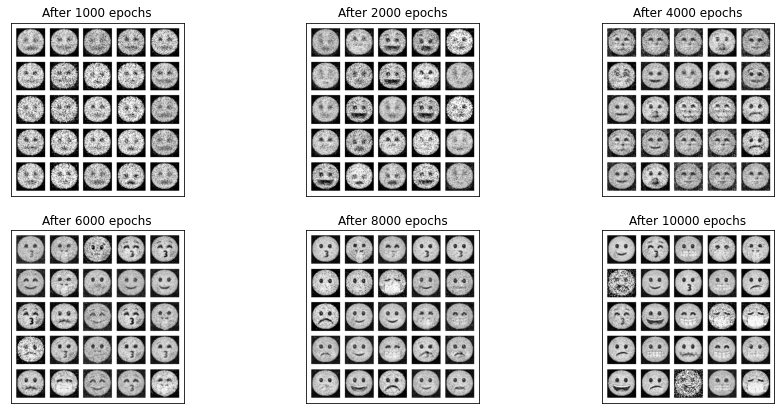

In [49]:
plt.figure(figsize =(15, 7))
i=1000
c=0
while i<=10000:
    plt.subplot(2, 3, c + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img_path = os.path.join('/content/images/', str(i)+'_gen_emoji.png')
    plt.imshow(cv2.imread(img_path), cmap = 'gray')
    plt.title("After "+str(i)+" epochs")
    i += 1000
    if i >=2001: i += 1000
    c += 1 
plt.show()

**Saving the Generator model**

In [50]:
G.save('generator_face_emoji.h5')